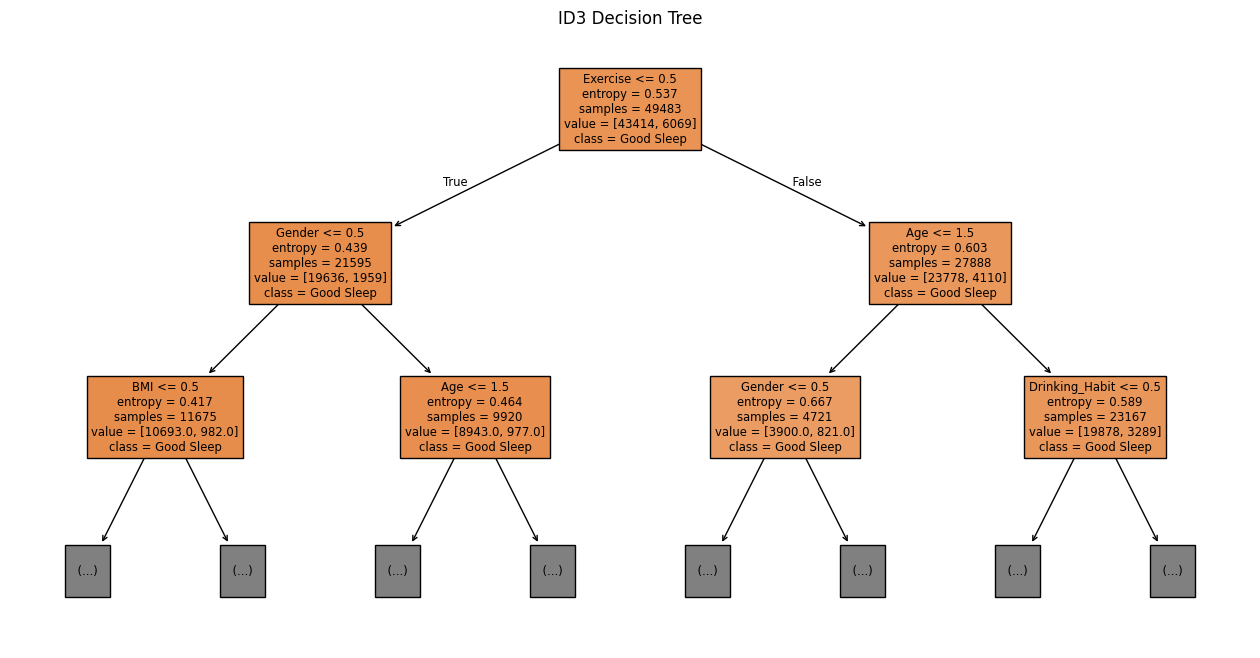

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from math import log2


# Load and Clean Data
df = pd.read_csv("sleep_health.csv").dropna()

df_2015 = pd.DataFrame({
    "Poor_Sleep": df["2015NRS"],
    "Gender": df["gender"],
    "Age": df["2015Age"],
    "BMI": df["2015BMI"],
    "Smoking": df["2015Smoking"],
    "Exercise": df["2015EX"],
    "Diabetes": df["2015Diabetes"],
    "Drinking_Habit": df["2015DrinkHabit"],
    "Hypertension": df["2015Hypertension"]
})

# Bin Age and BMI
df_2015["Age"] = pd.cut(df_2015["Age"], bins=[39, 49, 59, 69, 74], labels=["40–49", "50–59", "60–69", "70–74"])
df_2015["BMI"] = pd.cut(df_2015["BMI"], bins=[0, 18.5, 25, float("inf")], labels=["Underweight", "Normal", "Overweight"])

# Encode all features
le = LabelEncoder()
for col in df_2015.columns:
    df_2015[col] = le.fit_transform(df_2015[col])

# Train ID3 Tree
target = "Poor_Sleep"
features = [col for col in df_2015.columns if col != target]
X = df_2015[features]
y = df_2015[target]


clf_unbalanced = DecisionTreeClassifier(criterion="entropy", max_depth=8, random_state=42)
clf_unbalanced.fit(X, y)

# Plot Decision Tree 
plt.figure(figsize=(16, 8))
plot_tree(
    clf_unbalanced,
    feature_names=features,
    class_names=["Good Sleep", "Poor Sleep"],
    filled=True,
    max_depth=2
)
plt.title("ID3 Decision Tree")
plt.show()


<Axes: >

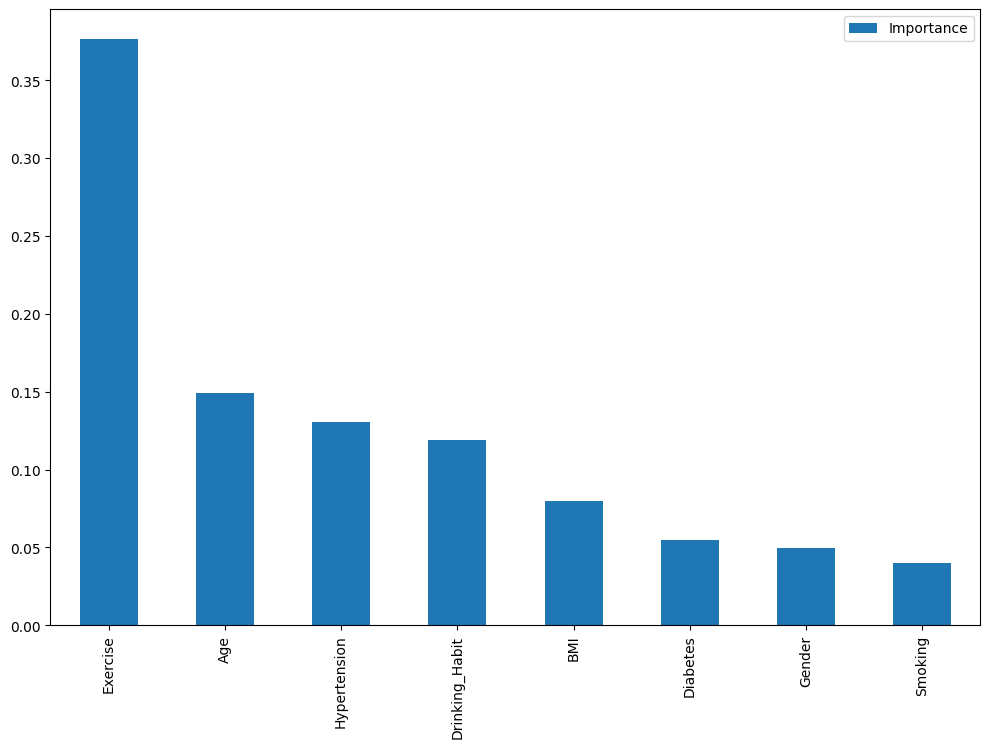

In [28]:
unbalanced_FI = clf_unbalanced.feature_importances_ 

feat_importances = pd.DataFrame(unbalanced_FI, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,8))

In [ ]:
# Random Forest Classifier
unbalanced_forest = RandomForestClassifier(criterion="entropy", random_state=42)
unbalanced_forest.fit(X, y)

RandomForestClassifier(criterion='entropy', random_state=42)

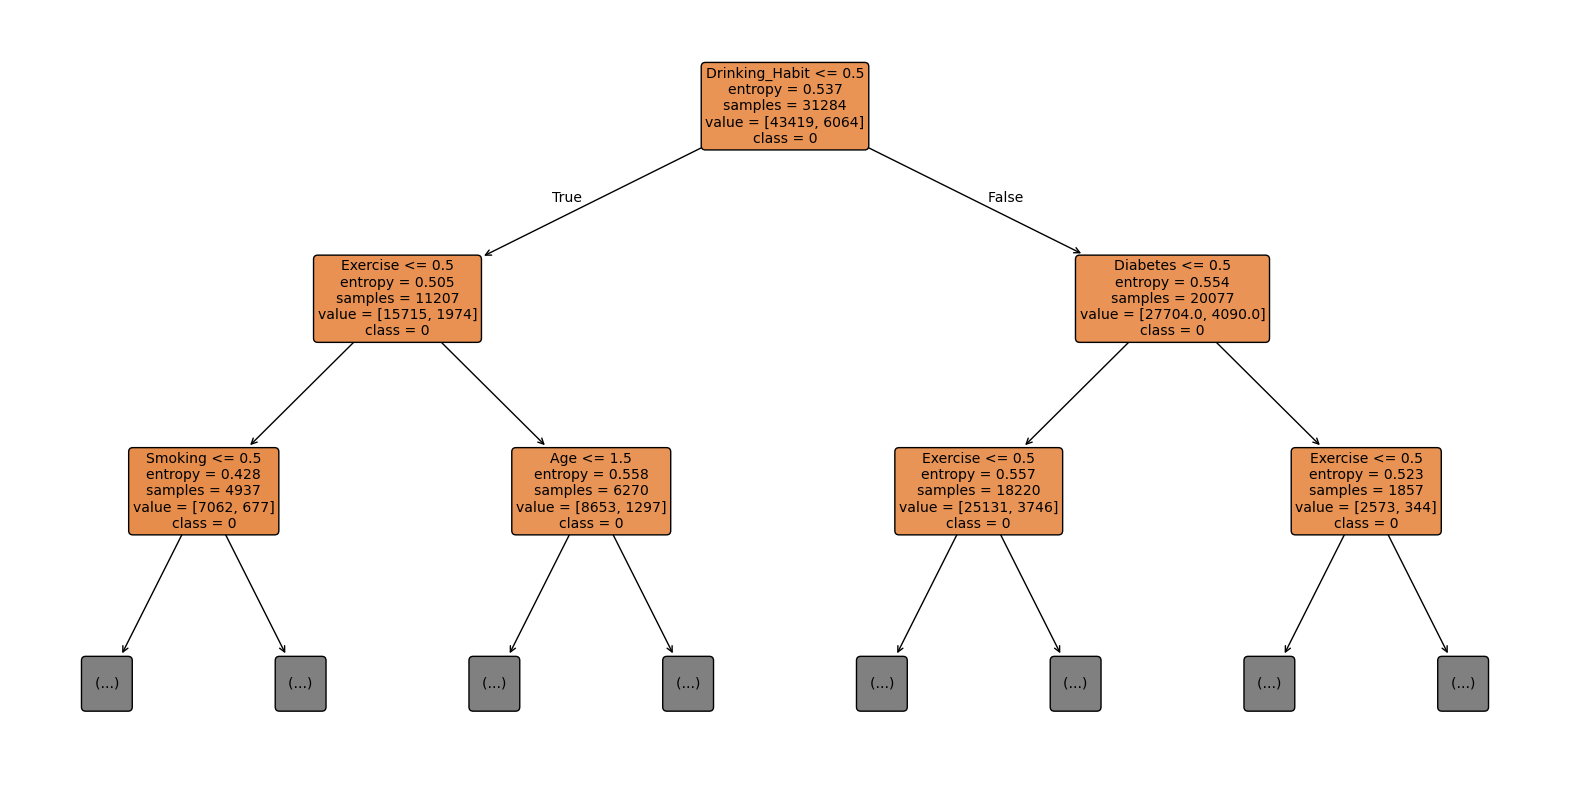

In [30]:
plt.figure(figsize=(20, 10))
plot_tree(unbalanced_forest.estimators_[0], 
          feature_names=X.columns, 
          class_names=[str(cls) for cls in unbalanced_forest.classes_],
          filled=True, 
          rounded=True,
          max_depth=2)
          
plt.show()

<Axes: >

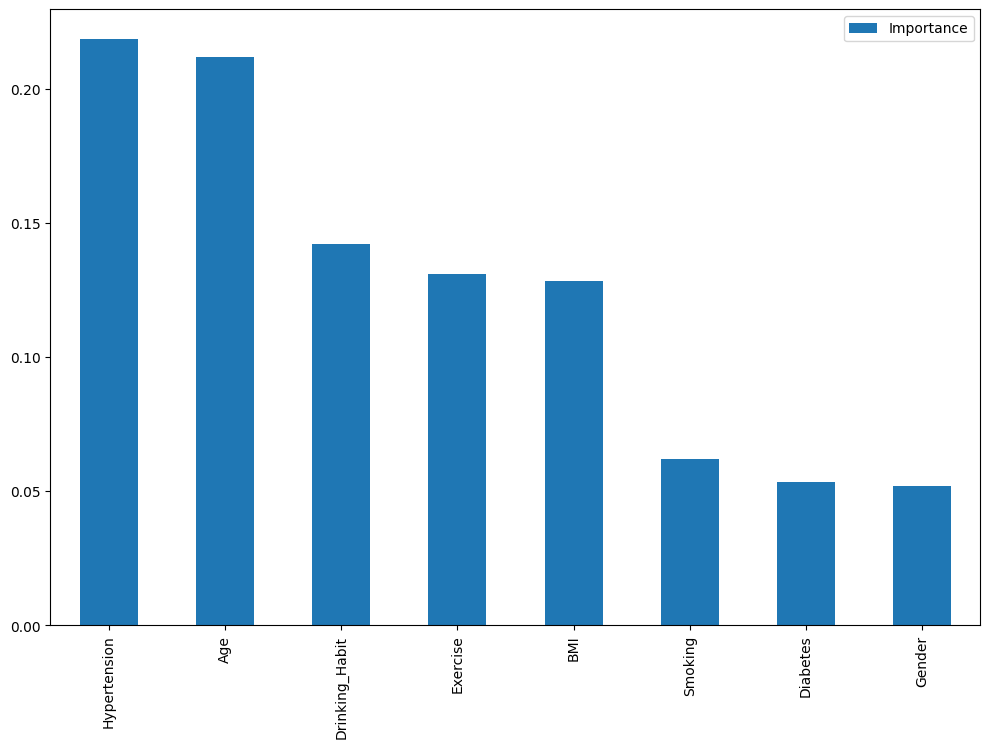

In [31]:
# this is better to look at than information gain
unbalanced_FI = unbalanced_forest.feature_importances_ # how much does this feature account for the variance

feat_importances = pd.DataFrame(unbalanced_FI, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,8))

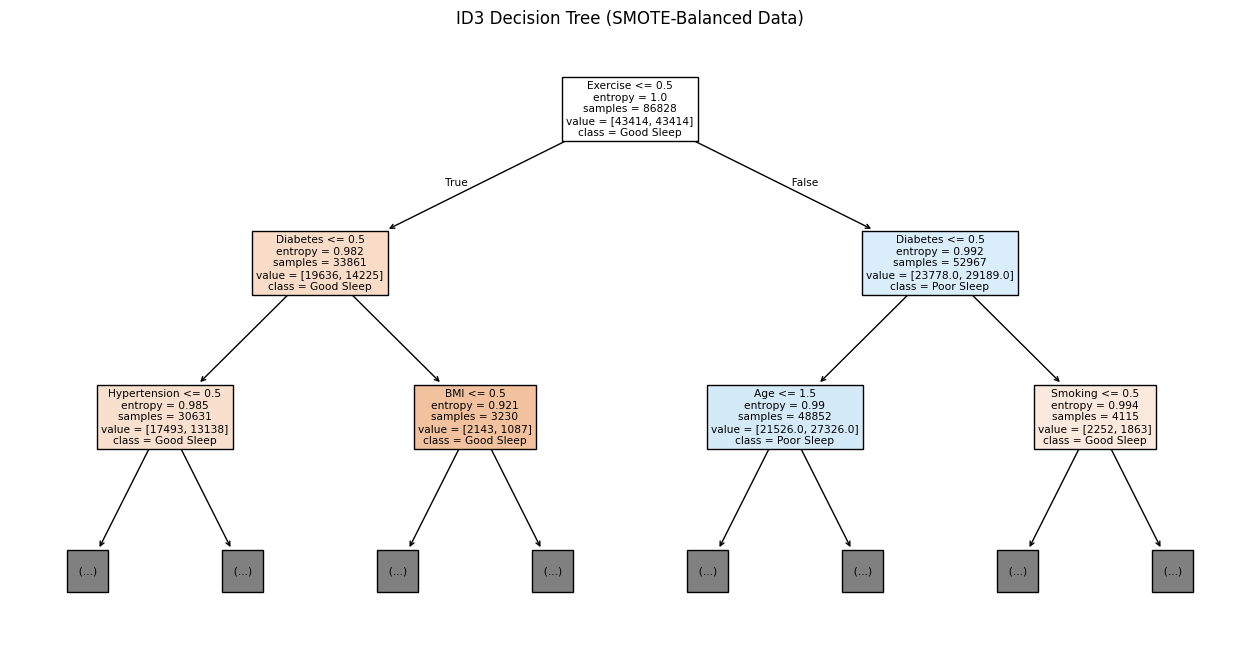

In [ ]:
# Apply SMOTE to Balance Dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

df_smote = pd.DataFrame(X_resampled, columns=features)
df_smote["Poor_Sleep"] = y_resampled

# Train ID3 after SMOTE
clf_balanced = DecisionTreeClassifier(criterion="entropy", max_depth=8, random_state=42)
clf_balanced.fit(X_resampled, y_resampled)

# Plot Decision Tree
plt.figure(figsize=(16, 8))
plot_tree(
    clf_balanced,
    feature_names=features,
    class_names=["Good Sleep", "Poor Sleep"],
    filled=True,
    max_depth=2
)
plt.title("ID3 Decision Tree (SMOTE-Balanced Data)")
plt.show()

<Axes: >

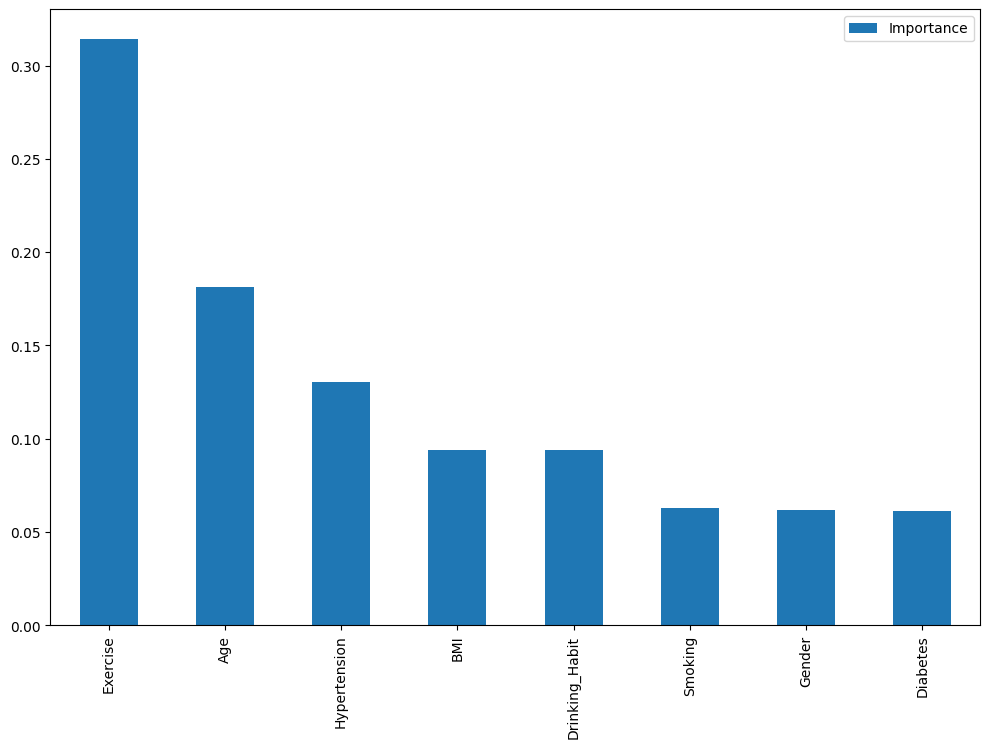

In [34]:
balanced_FI = clf_balanced.feature_importances_ 

feat_importances = pd.DataFrame(balanced_FI, index=X_resampled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(12,8))

Information Gain Comparison:
       Feature  Information Gain_Unbalanced  Information Gain_SMOTE
      Exercise                     0.005430                0.011815
           Age                     0.001277                0.003891
      Diabetes                     0.000141                0.002595
  Hypertension                     0.000463                0.001392
        Gender                     0.000688                0.000704
       Smoking                     0.000003                0.000589
Drinking_Habit                     0.000370                0.000548
           BMI                     0.000252                0.000146


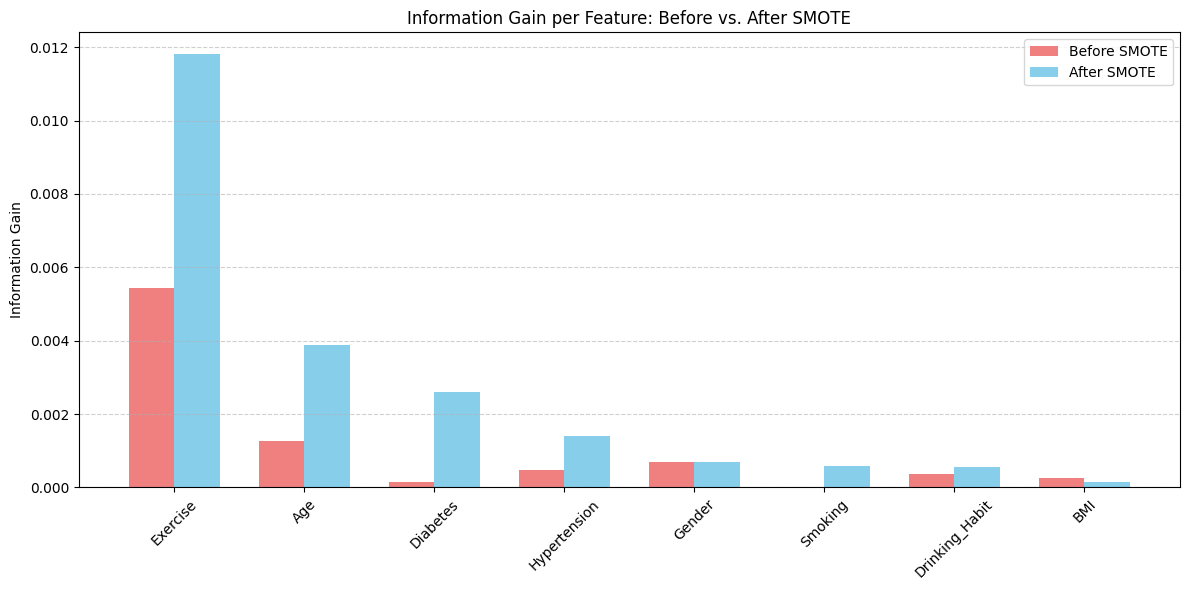

In [35]:
# Compare Info Gain
compare_df = info_gain_df_unbalanced.merge(
    info_gain_df_balanced, on="Feature"
).sort_values("Information Gain_SMOTE", ascending=False)

print("Information Gain Comparison:")
print(compare_df.to_string(index=False))

# Bar Chart for comparison
x = np.arange(len(compare_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, compare_df["Information Gain_Unbalanced"], width, label="Before SMOTE", color="lightcoral")
plt.bar(x + width/2, compare_df["Information Gain_SMOTE"], width, label="After SMOTE", color="skyblue")
plt.xticks(ticks=x, labels=compare_df["Feature"], rotation=45)
plt.ylabel("Information Gain")
plt.title("Information Gain per Feature: Before vs. After SMOTE")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()

Feature Importance Comparison:
       Feature  Feature Importance_Unbalanced  Feature Importance_Balanced
      Exercise                       0.130885                     0.314442
           Age                       0.211854                     0.181087
  Hypertension                       0.218871                     0.130141
           BMI                       0.128394                     0.094166
Drinking_Habit                       0.142327                     0.093845
       Smoking                       0.062197                     0.062882
        Gender                       0.052104                     0.061996
      Diabetes                       0.053369                     0.061440


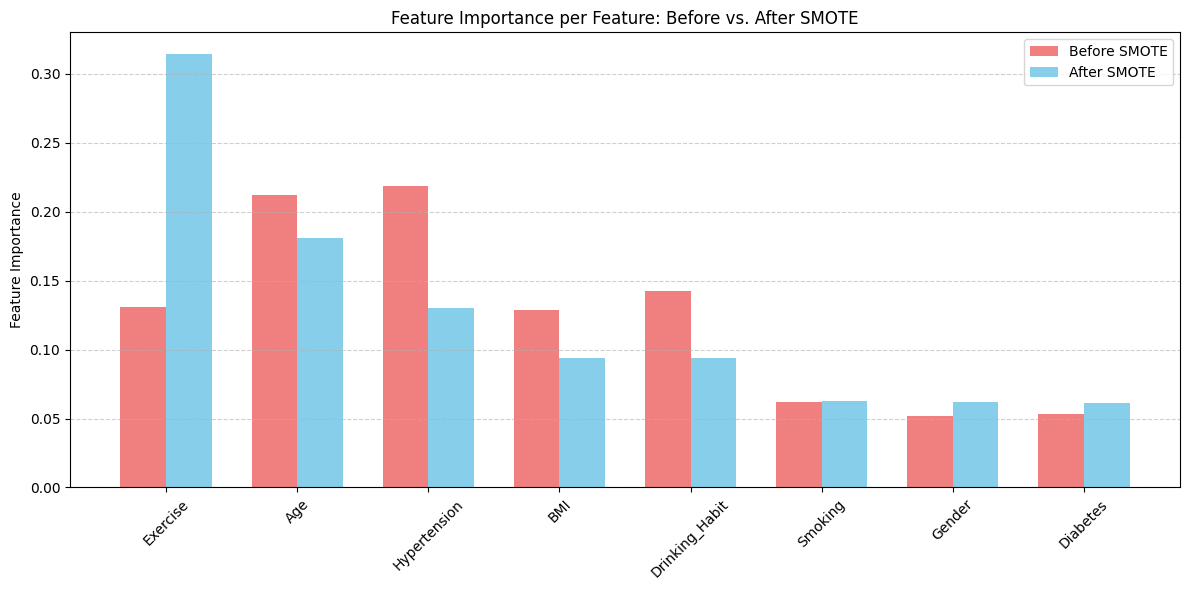

In [36]:
# Compare feature importance
fi_df_unbalanced = pd.DataFrame({
    "Feature": X.columns,
    "Feature Importance_Unbalanced": unbalanced_FI
})
fi_df_balanced = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Feature Importance_Balanced": balanced_FI
})

compare_df = pd.merge(fi_df_unbalanced, fi_df_balanced, on="Feature", how="inner")
compare_df.sort_values("Feature Importance_Balanced", ascending=False, inplace=True)

print("Feature Importance Comparison:")
print(compare_df.to_string(index=False))

# Bar Chart for comparison
x = np.arange(len(compare_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, compare_df["Feature Importance_Unbalanced"], width, label="Before SMOTE", color="lightcoral")
plt.bar(x + width/2, compare_df["Feature Importance_Balanced"], width, label="After SMOTE", color="skyblue")
plt.xticks(ticks=x, labels=compare_df["Feature"], rotation=45)
plt.ylabel("Feature Importance")
plt.title("Feature Importance per Feature: Before vs. After SMOTE")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle="--", alpha=0.6)
plt.show()